# **CS598 Coding Assignment 3**

# **Team Members**

Zilal Eiz Aldin (Online MCS) Zelalae2@illinois.edu

Mesay Taye (Online MCS) mesayst2@illinois.edu

Jianci Zhai (Online MCS) jianciz2@illinois.edu

# **Contribution of each member**

Part3 By Mesay

Part2 By Zilal

Part1 By Jianci

**Reference**

https://campuswire.com/c/GB46E5679/feed/337

Ridgless: https://campuswire.com/c/GB46E5679/feed/338



# **Basic Setting**

In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


from scipy import stats
from scipy.optimize import minimize_scalar

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression as lm
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from google.colab import drive
drive.mount('/content/drive')

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import SplineTransformer
from sklearn.cluster import KMeans


np.random.seed(3113)

Mounted at /content/drive


# **Part I: Optimal span for LOESS**

In [ ]:
!pip install scikit-misc==0.3.1 #match the exact version from the reference, function output keywords slightly different

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 5.7 MB/s eta 0:00:00


In [ ]:
!pip install csaps

In [ ]:
from skmisc.loess import loess
from csaps import csaps

In [100]:
coding3_data = pd.read_csv("https://liangfgithub.github.io/Data/Coding3_Data.csv")

Task 1. Write a function to retrieve the Diagonal of the Smoother Matrix

reference:
https://has2k1.github.io/scikit-misc/stable/generated/skmisc.loess.loess_outputs.html#skmisc.loess.loess_outputs

In [ ]:
'''
the input of this function can only be x and span, not y
'''

def sm_diag(x,span):
  from skmisc.loess import loess
  lowess_model = loess(x.flatten(), x.flatten(),span = span)
  lowess_model.fit()
  return lowess_model.outputs.diagonal.reshape(-1,1)


Task 2. Write a function to find the Optimal Span(s) based on CV and GCV.


• Iterate over the specified span values.

• For each span, calculate the CV and GCV values.

• Return the CV and GCV values corresponding to each span.

In [ ]:
def smooth(x, y, fx, lam, axis=-1):
    return csaps(x, y, fx, smooth=1/(lam + 1), axis=-1)

def S_lam(x, lam):
    n = len(x)
    Y = np.identity(n)
    A = smooth(x, Y, x, lam, axis=0)
    return (A + A.T)/2


def df_to_lam(x, df):
    def g(lam):
        return (S_lam(x, lam).trace() - df)**2
    return minimize_scalar(g, bounds=(0, 10), options={'xatol': 1e-10}).x


def smooth_df(x, y, fx, df, axis=-1):
    return smooth(x, y, fx, df_to_lam(x, df), axis)


def S_df(x, df):
    return S_lam(x, df_to_lam(x,  df))

def gcv(x, y, df):
    n=len(x)
    fit = smooth_df(x, y, x, df)
    return (((y - fit) ** 2) / ((1 - df/n) ** 2)).mean()

def lcv(x, y, df):

    fit = smooth_df(x, y, x, df)
    lev = np.diag(S_df(x, df=df))
    return (((y - fit) ** 2) / ((1 - lev) ** 2)).mean()

In [ ]:
def os_srch(span_values,x,y):
  output = []
  for i,span in enumerate(span_values):
    df = sm_diag(x,span).sum()
    gcv_output = gcv(x, y, df)
    lcv_output = lcv(x, y, df)
    output.append([i,span, gcv_output, lcv_output])

    print(f"i={i};span={span}; df={df};  gcv_output={gcv_output};" +f"lcv_output={lcv_output}\n")

  output_pd = pd.DataFrame(output, columns=['I', 'Span','GCV','LCV'])

  min_gcv = output_pd ['GCV'].idxmin()
  min_lcv = output_pd ['LCV'].idxmin()

  min_gcv_ss = output_pd.loc[min_gcv, 'GCV']
  min_lcv_ss = output_pd.loc[min_lcv, 'LCV']

  min_gcv_span = output_pd.loc[min_gcv, 'Span']
  min_lcv_span = output_pd.loc[min_lcv, 'Span']

  print(f"when span={min_gcv_span} reach minimium gcv={min_gcv_ss};\n")
  print(f"when span={min_lcv_span} reach minimium lcv={min_lcv_ss};\n")

  return output_pd,min_gcv_span,min_gcv_span

Task3. Test your code

In [ ]:
'''
both LCV and GCV returned the same best span = 0.45
'''

span_values = np.around(np.linspace(0.2, 0.9, 15),2)
x = coding3_data['x'].values
y = coding3_data['y'].values
os_srch_output = os_srch(span_values,x,y)

i=0;span=0.2; df=19.345217226844355;  gcv_output=1.6710117641094278;lcv_output=1.613230191203891

i=1;span=0.25; df=15.777152922113022;  gcv_output=1.2887451485465293;lcv_output=1.380277273478569

i=2;span=0.3; df=12.122018174055317;  gcv_output=1.1227484199926239;lcv_output=1.2135348021011052

i=3;span=0.35; df=10.517367801142218;  gcv_output=1.0717521082350998;lcv_output=1.1698762202082633

i=4;span=0.4; df=8.80421626094609;  gcv_output=1.0406614784944097;lcv_output=1.1447392279259097

i=5;span=0.45; df=8.070686758968673;  gcv_output=1.0393400442575196;lcv_output=1.1419571929915173

i=6;span=0.5; df=7.174678445276332;  gcv_output=1.059367849909726;lcv_output=1.1581246687337605

i=7;span=0.55; df=6.136483979033964;  gcv_output=1.1510552330901807;lcv_output=1.246182440938056

i=8;span=0.6; df=5.868174542094999;  gcv_output=1.195097161254625;lcv_output=1.2896168170738365

i=9;span=0.65; df=5.359664205165414;  gcv_output=1.3099418132515757;lcv_output=1.403341589191035

i=10;span=0.7; df=

In [ ]:
output_pd,min_gcv_span,min_gcv_span=os_srch_output

'\ndouble check the trend of LCV and GCV - pretty consistent for this dataset\n'

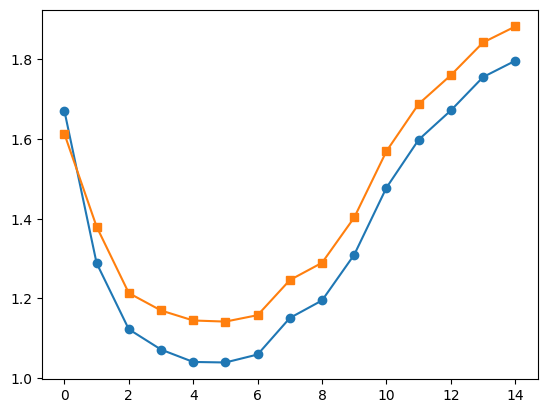

In [ ]:
plt.plot(output_pd.index, output_pd['GCV'], label='GCV', marker='o')
plt.plot(output_pd.index, output_pd['LCV'], label='LCV', marker='s')
'''
double check the trend of LCV and GCV - pretty consistent for this dataset
'''


- Fit a LOESS model over the entire dataset using the selected optimal span.


In [ ]:
best_span = 0.45

In [ ]:
def f(x):
    return np.sin(12 * (x + 0.2)) / (x + 0.2)

err = 1
x = coding3_data['x'].values
y = coding3_data['y'].values
fx = np.arange(1, 51, 1)/50
fy = f(fx)

In [ ]:
lowess_model = loess(x=x, y=y, span=0.45) #use x to fill in y because y is irrelevant
lowess_model.fit()
py = lowess_model.predict(x)

Display a chart

In [ ]:
px2 = np.arange(1, 51, 0.5)/50
py2_1= f(px2)+ np.random.normal(0, err, 100)
lowess_model2 = loess(x=px2, y=py2_1, span=0.45) #use x to fill in y because y is irrelevant
py2 = lowess_model2.predict(px2)

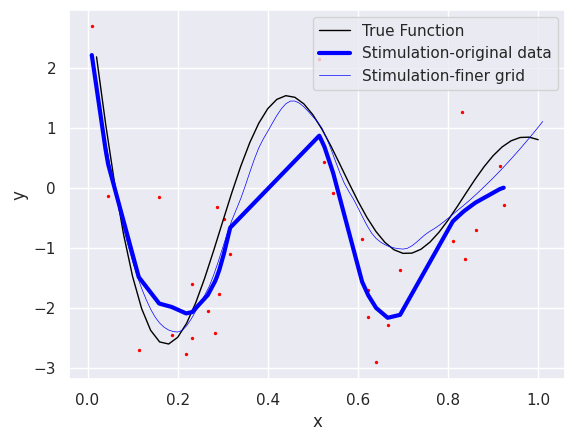

In [ ]:
sns.set()
mpl.rcParams['figure.dpi'] = 100
plt.scatter(x, y, color="red", s=2)
plt.plot(fx, fy, color="black", linewidth=1, label='True Function')
plt.plot(x, py, color="blue", linewidth=3, label='Stimulation-original data')
plt.plot(px2, py2, color="blue", linewidth=0.5, label='Stimulation-finer grid')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()


Additional Comment:

In the chart displayed, we observed a straight line connecting two points near the center. Upon investigation, we concluded that this occurred due to the sparse distribution of data points in the middle section of the chart, which led the smoothing matrix to approximate a straight line between these points.

To validate this hypothesis, we generated a finer grid with more evenly distributed points across the range. When applied to the smoothing matrix, this finer grid produced a curve that more closely resembled the true function, confirming our initial hypothesis.

## Part 1 Optimal span for LOESS By Zilal
Reference: https://www.coursera.org/learn/cs-598-psl/lecture/Vu0br/local-regression-in-r

In [93]:
"""
1- fit a loess model y1=x1 with span = sp, and extract
   the corresponding residual vector
2- call S_lam to obrain the diagonal entries of S
3- compute LOO-CV and GCV
"""
# Helper function to retrieve the diagonal of the smoother matrix S
def S_lam(x, span):
# Fit a LOESS model with a fake y vector (diagonal entries of S are independent of y)
    n = len(x)
    S_diag = np.zeros(n)

    # Loop through each point and perturb the y values slightly
    for i in range(n):
        # Perturb the i-th point
        y_perturbed = np.zeros(n)
        y_perturbed[i] = 1

        # Fit LOESS model with perturbed y
        loess_fit = loess(x, y_perturbed, span=span)
        loess_fit.fit()

        # Predict values (fitted values will form one row of S)
        S_diag[i] = loess_fit.predict(x).values[i]

    return S_diag


In [98]:
def loo_cv(x, y, span):
    """
    Compute the Leave-One-Out Cross-Validation (LOO-CV) for a given span.

    Inputs:
    - x: an n-by-1 feature vector (input data)
    - y: target values
    - span: a numerical value representing the span for LOESS

    Output:
    - LOO-CV error
    """
    loess_fit = loess(x, y, span=span)
    loess_fit.fit()
    y_pred = loess_fit.predict(x).values
    residuals = y - y_pred
    S_diag = S_lam(x, span)

    # Compute LOO-CV error
    loo_errors = residuals / (1 - S_diag)
    loo_cv_error = np.mean(loo_errors**2)

    return loo_cv_error

def gcv(x, y, span):
    """
    Compute the Generalized Cross-Validation (GCV) for a given span.

    Inputs:
    - x: an n-by-1 feature vector (input data)
    - y: target values
    - span: a numerical value representing the span for LOESS

    Output:
    - GCV error
    """
    loess_fit = loess(x, y, span=span)
    loess_fit.fit()
    y_pred = loess_fit.predict(x).values
    residuals = y - y_pred
    S_diag = S_lam(x, span)

    # Effective degrees of freedom
    edf = np.sum(S_diag)

    # Compute GCV error
    gcv_error = np.mean(residuals**2) / ((1 - edf / len(x))**2)

    return gcv_error

def find_optimal_span(x, y, span_values):
    """
    Find the optimal span based on CV and GCV.

    Inputs:
    - x: an n-by-1 feature vector (input data)
    - y: target values
    - span_values: a list of span values to test

    Output:
    - cv_errors: list of LOO-CV errors for each span
    - gcv_errors: list of GCV errors for each span
    - best_span: span with the lowest CV and GCV errors
    """
    cv_errors = []
    gcv_errors = []

    for span in span_values:
        cv_error = loo_cv(x, y, span)
        gcv_error = gcv(x, y, span)
        cv_errors.append(cv_error)
        gcv_errors.append(gcv_error)

    # Find the best span based on the minimum CV error
    best_span = span_values[np.argmin(cv_errors)]

    return cv_errors, gcv_errors, best_span


In [112]:
def plot_results(x, y, best_span):
    """
    Plot the original data points and fitted curve using the optimal span.

    Inputs:
    - x: feature vector
    - y: target values
    - best_span: the optimal span for LOESS
    """
    loess_fit = loess(x, y, span=best_span)
    loess_fit.fit()

    # Generate a finer grid for plotting a smooth curve
    x_fine = np.linspace(min(x), max(x), 500)
    y_fitted = loess_fit.predict(x_fine).values

    # Plot original data points and fitted curve
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, label='Original data', color='gray', s=50, facecolor='none')
    plt.plot(x_fine, y_fitted, label='Fitted LOESS Curve', color='blue', linewidth=2, linestyle='--')

    # True curve: f(x) = sin(12*(x+0.2))/(x+0.2)
    true_curve = np.sin(12 * (x_fine + 0.2)) / (x_fine + 0.2)
    plt.plot(x_fine, true_curve, label='True Curve', color='grey')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title(f'LOESS with optimal span {best_span}')
    plt.show()



In [101]:
#Testing
coding3_data = pd.read_csv("https://liangfgithub.github.io/Data/Coding3_Data.csv")

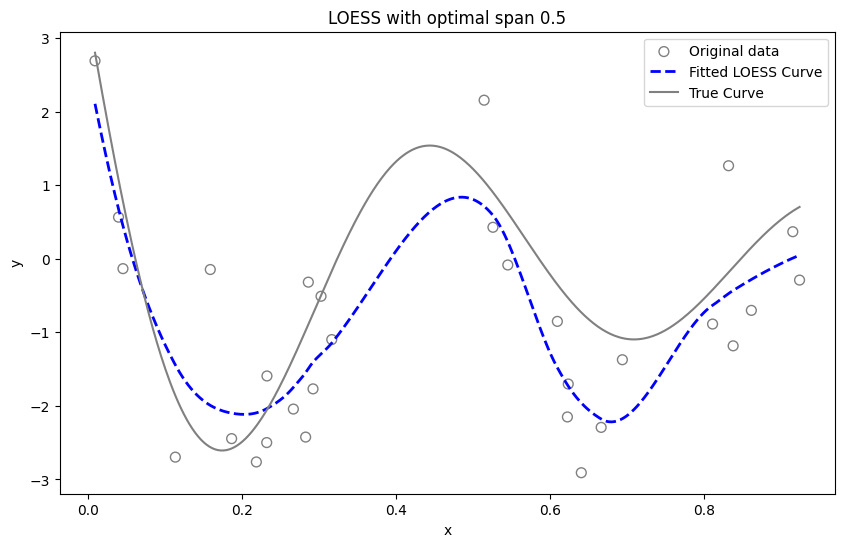

LOO-CV errors for each span: [12.415910699869332, 2.2414734958901574, 1.5029798111583716, 1.2591747084691483, 1.190379927991338, 1.1568121230625679, 1.1243056621273273, 1.1796637523744389, 1.1794641625428166, 1.2509138273813027, 1.5535622642533482, 1.6361746170729459, 1.7645336266044542, 1.9760935148587317, 2.0351079200441435]
GCV errors for each span: [2.110161841942957, 1.4892056326217178, 1.190109844631824, 1.1744229564766888, 1.1025399038231014, 1.0625034645069504, 1.0404222708825765, 1.1188405514998314, 1.1192688072551897, 1.1805847769313833, 1.51909081281356, 1.6274293455726152, 1.7445490858435335, 1.92569596135356, 1.9798203978761495]
Best span based on LOO-CV and GCV: 0.5


In [113]:
# Test the code
x = coding3_data['x'].values
y = coding3_data['y'].values


# Define span values
span_values = np.around(np.linspace(0.2, 0.9, 15),2)


# Find optimal span
cv_errors, gcv_errors, best_span = find_optimal_span(x, y, span_values)

# Plot the results
plot_results(x, y, best_span)

# Report the errors
print("LOO-CV errors for each span:", cv_errors)
print("GCV errors for each span:", gcv_errors)
print("Best span based on LOO-CV and GCV:", best_span)




Text(0, 0.5, 'CV Score')

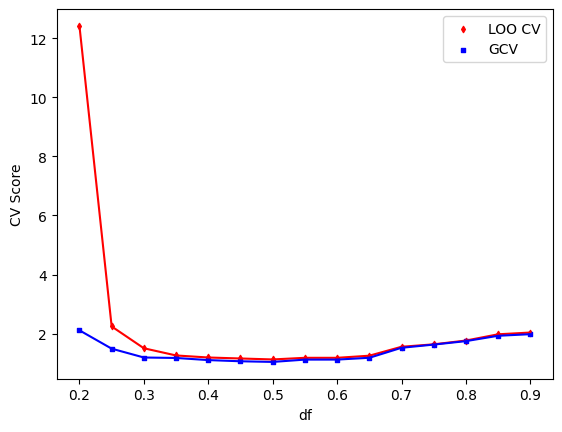

In [115]:
dfs = np.around(np.linspace(0.2, 0.9, 15),2)
m = len(dfs)
my_lcv = np.zeros(m)
my_gcv = np.zeros(m)
for i in range(m):
    df = dfs[i]
    my_gcv[i] = gcv(x, y, df)
    my_lcv[i] = loo_cv(x, y, df)
plt.plot(dfs, my_lcv, color='red')
plt.scatter(dfs, my_lcv, color='red', marker='d', s=10, label='LOO CV')
plt.plot(dfs, my_gcv, color='blue')
plt.scatter(dfs, my_gcv, color='blue', marker='s', s=10, label='GCV')
plt.legend()
plt.xlabel("df")
plt.ylabel("CV Score")


# **Part II: Ridgeless and Double Descent** By Zilal

In [ ]:
#initialize seed
np.random.seed(3113)

In [ ]:
coding3_dataH = pd.read_csv("https://liangfgithub.github.io/F22/Coding3_dataH.csv", header=None)
coding3_dataH.head()

,0,1,2,3,4,5,6,7,8,9,...,231,232,233,234,235,236,237,238,239,240
0,3.178054,0.0,0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.047122,0.0,0.000000,0.0,0.000000
1,3.072693,0.0,0,0.0,-0.007258,0.185217,0.000000,0.001372,0.0,0.0,...,0.000000,0.0,0.0,0.527546,0.000000,0.000000,0.0,0.059271,0.0,0.000000
2,3.546740,0.0,0,0.0,-0.007258,0.185217,0.000000,0.000000,0.0,0.0,...,-0.000028,0.0,0.0,0.527546,0.000000,0.000000,0.0,0.000000,0.0,0.000000
3,3.508556,0.0,0,0.0,-0.194452,0.005858,0.168630,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.452800,0.000000,0.000000,0.0,0.000000,0.0,0.000000
4,3.589059,0.0,0,0.0,-0.194452,0.005858,0.000004,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.452800,0.003294,0.000000,0.0,0.000000,0.0,0.491547


In [ ]:
coding3_dataH.shape

(506, 241)

**Task** 1: Ridgeless Function

In [ ]:
def ridgeless(train_data, test_data, eps=1e-10):
    # Step 1: Separate response Y and features X from the training and test datasets
    Y_train = train_data[:, 0]  # First column is Y for training
    X_train = train_data[:, 1:]  # Remaining columns are X for training

    Y_test = test_data[:, 0]  # First column is Y for test
    X_test = test_data[:, 1:]  # Remaining columns are X for test

    # Step 2: Center the training and test data (subtract the mean of each feature)
    X_train_mean = np.mean(X_train, axis=0)  # Mean of training features
    X_train_centered = X_train - X_train_mean  # Center the training data

    #reference: https://campuswire.com/c/GB46E5679/feed
    X_test_centered = X_test - X_train_mean  # Center the test data using the mean of training data

    # Step 3: Estimate the intercept (b0) as the mean of Y_train
    b0 = np.mean(Y_train)

    # Step 4: Perform Singular Value Decomposition (SVD) on the centered training data X_train
    U_train, S_train, Vt_train = np.linalg.svd(X_train_centered, full_matrices=True)

    # Step 5: Identify the number of singular values greater than eps, and truncate
    k = np.sum(S_train > eps)  # Number of significant singular values
    S_train_trunc = S_train[:k]  # Truncated singular values
    Vt_train_trunc = Vt_train[:k, :]  # Truncated right singular vectors (V^T matrix)

    # Step 6: Transform the centered training data into the truncated principal component space
    F_train = X_train_centered @ Vt_train_trunc.T

    # Step 7: Compute the least squares coefficients alpha
    # Since F.T @ F is diagonal, we can compute alpha without matrix inversion:
    # alpha = (U'Y) / S
    alpha = (U_train[:, :k].T @ Y_train) / S_train_trunc

    # Step 8: Compute predictions for the training data
    Y_train_pred = b0 + F_train @ alpha  # Training predictions: y_train_pred = b0 + F_train @ alpha

    # Step 9: Calculate the training error (Mean Squared Error)
    train_error = np.mean((Y_train - Y_train_pred) ** 2)

    # Step 10: Transform the centered test data into the truncated principal component space
    F_test = X_test_centered @ Vt_train_trunc.T  # F_test = X_test_centered * V_trunc

    # Step 11: Compute predictions for the test data
    Y_test_pred = b0 + F_test @ alpha

    # Step 12: Calculate the test error (Mean Squared Error)
    test_error = np.mean((Y_test - Y_test_pred) ** 2)

    # Return training and test errors
    return train_error, test_error

reference: https://campuswire.com/c/GB46E5679/feed/338


### **Task 2: Simulation study** By Zilal

Graphical display

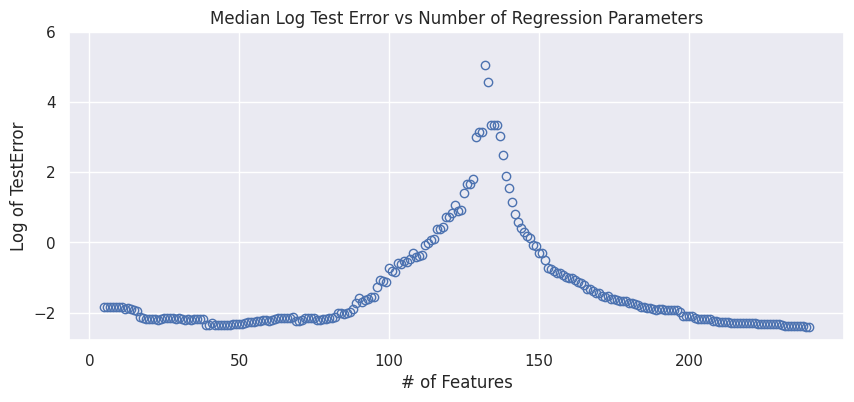

In [ ]:
def execute_ridgeless_procedure(data, T=30):
    # Initialize the matrix to store test errors, with dimensions 30 (iterations) x 236 (parameters)
    test_error_matrix = np.zeros((T, 236))

    # Loop over the number of iterations
    for t in range(T):
        # Partition the data into 25% training and 75% testing
        # random state within the loop have to be None or ignore: https://campuswire.com/c/GB46E5679/feed
        train_data, test_data = train_test_split(data, test_size=0.75, random_state=None)

        # Loop over the number of features d = 6 to 241
        for d in range(6, 242):
            # Extract the first 'd' columns (after the first Y column) of the train and test data
            train_subset = np.hstack((train_data[:, [0]], train_data[:, 1:d]))
            test_subset = np.hstack((test_data[:, [0]], test_data[:, 1:d]))

            # Calculate the test error using the ridgeless function
            _, test_error = ridgeless(train_subset, test_subset)

            # Store the log of the test error in the matrix
            test_error_matrix[t, d-6] = np.log(test_error)

    # Compute the median of the test errors across the 30 iterations for each parameter count
    median_test_errors = np.median(test_error_matrix, axis=0)

    # Plot the median test errors (in log scale) against the number of regression parameters (5 to 240)
    plt.figure(figsize=(10, 4))
    plt.plot(range(5, 241), median_test_errors, marker='o', color='b',linestyle='None', markerfacecolor='None',  markeredgecolor='b')
    plt.xticks(range(0, 241, 50))  # Set x-axis ticks at 50-unit intervals
    plt.yticks(range(-2, 7, 2))  # Set y-axis ticks at 2-unit intervals


    plt.xlabel('# of Features')
    plt.ylabel('Log of TestError')
    plt.title('Median Log Test Error vs Number of Regression Parameters')
    plt.show()

execute_ridgeless_procedure(coding3_dataH.to_numpy())


# **Part III: Clustering time series**

In [ ]:
#initialize seed
np.random.seed(3113)

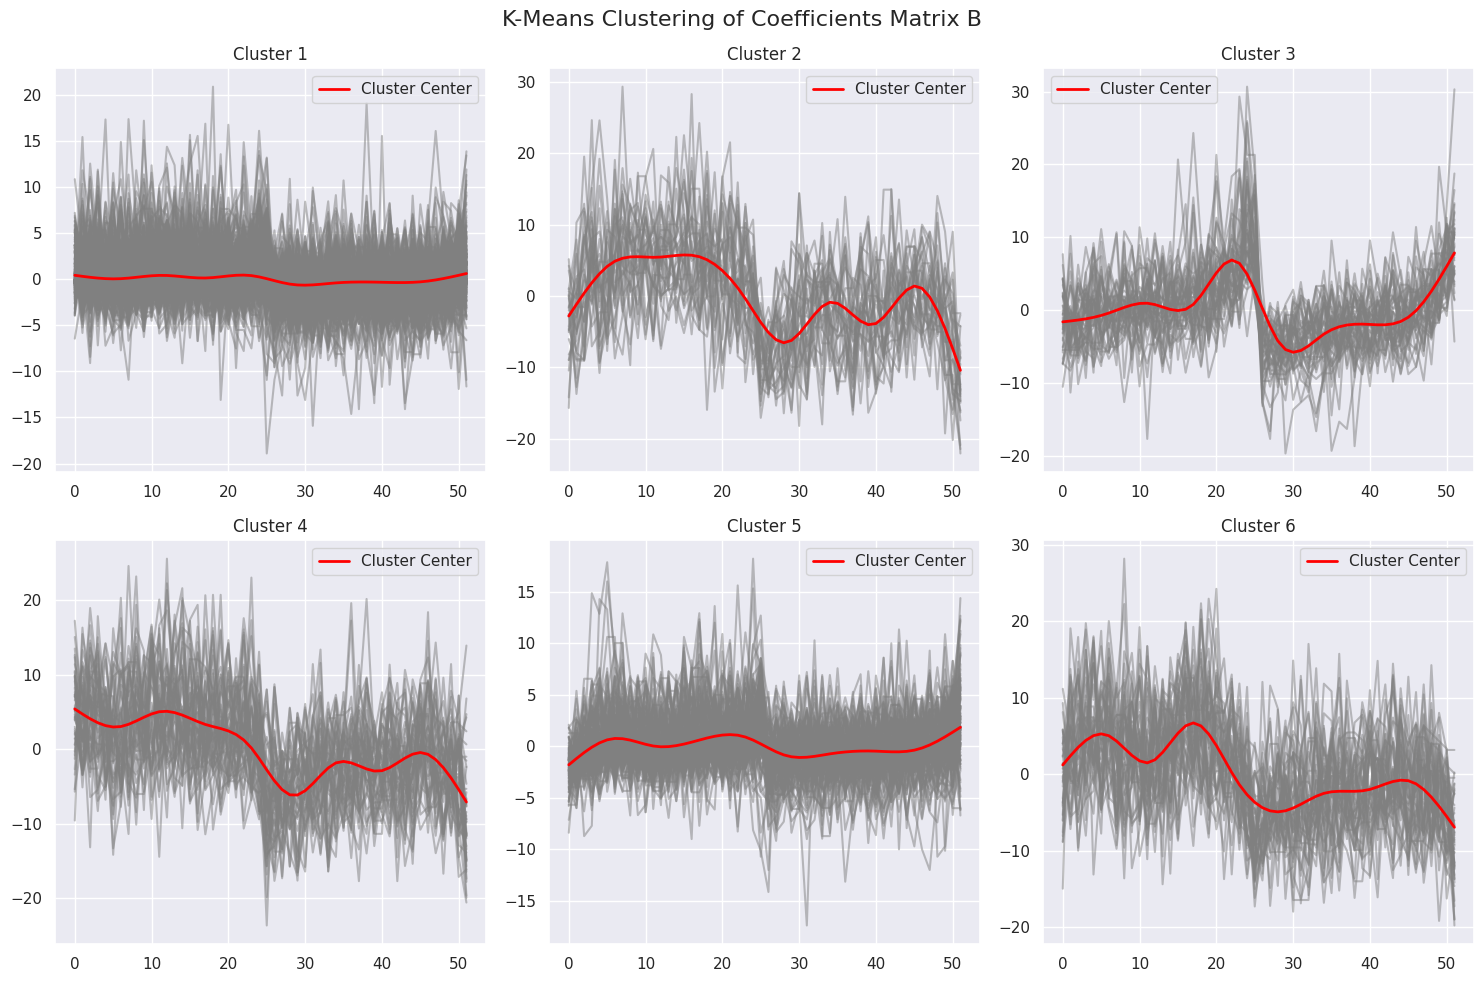

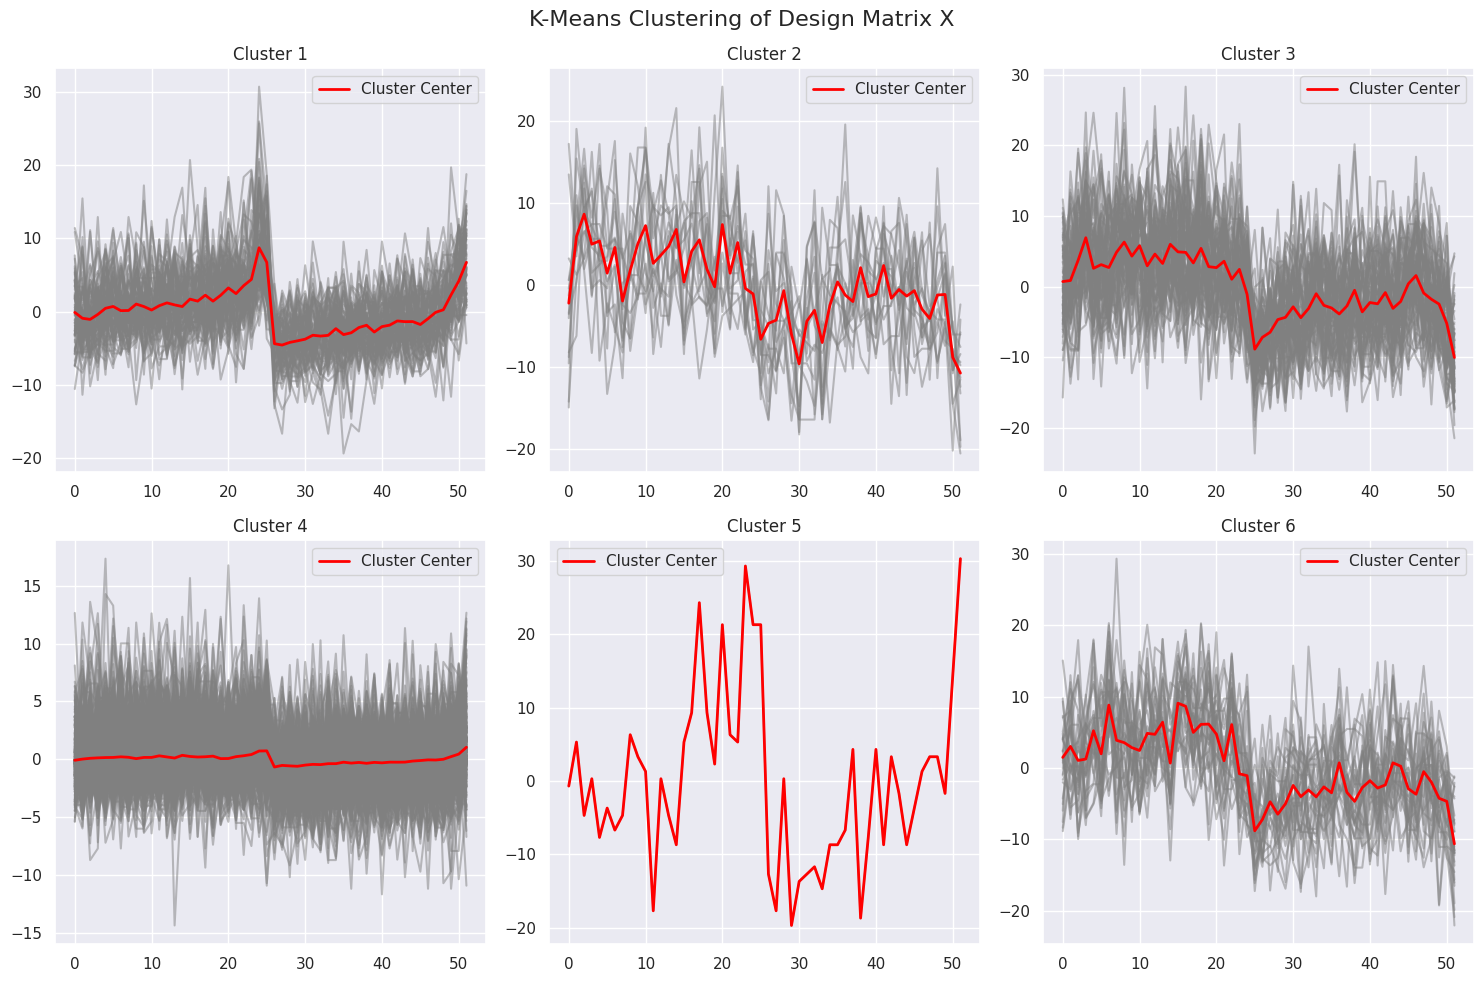

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.interpolate import splev

# Define the natural cubic spline function
def ns(x, df=None, knots=None, boundary_knots=None, include_intercept=False):
    degree = 3

    if boundary_knots is None:
        boundary_knots = [np.min(x), np.max(x)]
    else:
        boundary_knots = np.sort(boundary_knots).tolist()

    oleft = x < boundary_knots[0]
    oright = x > boundary_knots[1]
    outside = oleft | oright
    inside = ~outside

    if df is not None:
        nIknots = df - 1 - include_intercept
        if nIknots < 0:
            nIknots = 0

        if nIknots > 0:
            knots = np.linspace(0, 1, num=nIknots + 2)[1:-1]
            knots = np.quantile(x[~outside], knots)

    Aknots = np.sort(np.concatenate((boundary_knots * 4, knots)))
    n_bases = len(Aknots) - (degree + 1)

    if any(outside):
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        e = 1 / 4 # in theory anything in (0, 1); was (implicitly) 0 in R <= 3.2.2

        if any(oleft):
            k_pivot = boundary_knots[0]
            xl = x[oleft] - k_pivot
            xl = np.c_[np.ones(xl.shape[0]), xl]

            # equivalent to splineDesign(Aknots, rep(k.pivot, ord), ord, derivs)
            tt = np.empty((xl.shape[1], n_bases), dtype=float)
            for j in range(xl.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)

            basis[oleft, :] = xl @ tt

        if any(oright):
            k_pivot = boundary_knots[1]
            xr = x[oright] - k_pivot
            xr = np.c_[np.ones(xr.shape[0]), xr]

            tt = np.empty((xr.shape[1], n_bases), dtype=float)
            for j in range(xr.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)

            basis[oright, :] = xr @ tt

        if any(inside):
            xi = x[inside]
            tt = np.empty((len(xi), n_bases), dtype=float)
            for i in range(n_bases):
                coefs = np.zeros((n_bases,))
                coefs[i] = 1
                tt[:, i] = splev(xi, (Aknots, coefs, degree))

            basis[inside, :] = tt
    else:
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        for i in range(n_bases):
            coefs = np.zeros((n_bases,))
            coefs[i] = 1
            basis[:, i] = splev(x, (Aknots, coefs, degree))

    const = np.empty((2, n_bases), dtype=float)
    for i in range(n_bases):
        coefs = np.zeros((n_bases,))
        coefs[i] = 1
        const[:, i] = splev(boundary_knots, (Aknots, coefs, degree), der=2)

    if include_intercept is False:
        basis = basis[:, 1:]
        const = const[:, 1:]

    qr_const = np.linalg.qr(const.T, mode='complete')[0]
    basis = (qr_const.T @ basis.T).T[:, 2:]

    return basis

# Load and preprocess data
data = 'https://liangfgithub.github.io/Data/Sales_Transactions_Dataset_Weekly.csv'
X = pd.read_csv(data, usecols=[f'W{i}' for i in range(52)]).values
X_centered = X - X.mean(axis=1, keepdims=True)

# Create design matrix and compute coefficients
F = ns(np.arange(1, 53), df=9, include_intercept=False)
F_centered = F - F.mean(axis=0)
B = np.linalg.inv(F_centered.T @ F_centered) @ F_centered.T @ X_centered.T

# K-Means clustering
kmeans = KMeans(n_clusters=6, random_state=None)

# Function to plot clusters
def plot_clusters(data, centers, labels, title):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    for i, ax in enumerate(axes.flatten()):
        cluster_data = data[labels == i]
        ax.plot(cluster_data.T, color='grey', alpha=0.5)
        ax.plot(centers[i], color='red', linewidth=2, label='Cluster Center')
        ax.set_title(f'Cluster {i + 1}')
        ax.legend()
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Clustering on B
labels_B = kmeans.fit_predict(B.T)
cluster_centers_ts = F_centered @ kmeans.cluster_centers_.T
plot_clusters(X_centered, cluster_centers_ts.T, labels_B, 'K-Means Clustering of Coefficients Matrix B')

# Clustering on X_centered
labels_X = kmeans.fit_predict(X_centered)
plot_clusters(X_centered, kmeans.cluster_centers_, labels_X, 'K-Means Clustering of Design Matrix X')


###part 3 By Zilal

##Reference:
- Part 3(NCS): https://liangfgithub.github.io/Python_W5_RegressionSpline.html

To inspect the basis functions of a natural cubic spline, utilize the ns command. There are 10 basis functions for NCS with 10 knots (8 interior knots and 2 boundary knots).



In [ ]:
from scipy.interpolate import splev, interp1d
#initialize seed
np.random.seed(3113)

 #converted from R's ns()
def ns(x, df=None, knots=None, boundary_knots=None, include_intercept=False):
    degree = 3

    if boundary_knots is None:
        boundary_knots = [np.min(x), np.max(x)]
    else:
        boundary_knots = np.sort(boundary_knots).tolist()

    oleft = x < boundary_knots[0]
    oright = x > boundary_knots[1]
    outside = oleft | oright
    inside = ~outside

    if df is not None:
        nIknots = df - 1 - include_intercept
        if nIknots < 0:
            nIknots = 0

        if nIknots > 0:
            knots = np.linspace(0, 1, num=nIknots + 2)[1:-1]
            knots = np.quantile(x[~outside], knots)

    Aknots = np.sort(np.concatenate((boundary_knots * 4, knots)))
    n_bases = len(Aknots) - (degree + 1)

    if any(outside):
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        e = 1 / 4 # in theory anything in (0, 1); was (implicitly) 0 in R <= 3.2.2

        if any(oleft):
            k_pivot = boundary_knots[0]
            xl = x[oleft] - k_pivot
            xl = np.c_[np.ones(xl.shape[0]), xl]

            # equivalent to splineDesign(Aknots, rep(k.pivot, ord), ord, derivs)
            tt = np.empty((xl.shape[1], n_bases), dtype=float)
            for j in range(xl.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)

            basis[oleft, :] = xl @ tt

        if any(oright):
            k_pivot = boundary_knots[1]
            xr = x[oright] - k_pivot
            xr = np.c_[np.ones(xr.shape[0]), xr]

            tt = np.empty((xr.shape[1], n_bases), dtype=float)
            for j in range(xr.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)

            basis[oright, :] = xr @ tt

        if any(inside):
            xi = x[inside]
            tt = np.empty((len(xi), n_bases), dtype=float)
            for i in range(n_bases):
                coefs = np.zeros((n_bases,))
                coefs[i] = 1
                tt[:, i] = splev(xi, (Aknots, coefs, degree))

            basis[inside, :] = tt
    else:
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        for i in range(n_bases):
            coefs = np.zeros((n_bases,))
            coefs[i] = 1
            basis[:, i] = splev(x, (Aknots, coefs, degree))

    const = np.empty((2, n_bases), dtype=float)
    for i in range(n_bases):
        coefs = np.zeros((n_bases,))
        coefs[i] = 1
        const[:, i] = splev(boundary_knots, (Aknots, coefs, degree), der=2)

    if include_intercept is False:
        basis = basis[:, 1:]
        const = const[:, 1:]

    qr_const = np.linalg.qr(const.T, mode='complete')[0]
    basis = (qr_const.T @ basis.T).T[:, 2:]

    return basis

In [ ]:
from scipy.linalg import pinv

warnings.filterwarnings('ignore')

data_path = 'https://liangfgithub.github.io/Data/Sales_Transactions_Dataset_Weekly.csv'
df = pd.read_csv(data_path)

# Extract and center weekly sales
weekly_cols = [f'W{i}' for i in range(52)]
X = df[weekly_cols].values
X_centered = X - X.mean(axis=1, keepdims=True)


# Define the index as the feature (1 to 52)
index = np.arange(1, 53)

# Initialize the matrix to store the NCS coefficients
B = np.zeros((811, 9))  # 811 products, 9 coefficients

# Fit NCS for each time series (each row of X)
# for i in range(X_centered.shape[0]):
    # Create the design matrix F (52x9)
F = ns(index, df=9, include_intercept=False)

    # Center the design matrix by removing the column means
F_centered = F - np.mean(F, axis=1)[:,None]
    # Initialize matrix B to store coefficients
B = np.zeros((811, 9))  # 811 products, 9 coefficients
B=(np.linalg.inv(F_centered.T @ F_centered) @ F_centered.T @ X_centered.T).T


print((B.shape))



(811, 9)


In [ ]:
# Run K-Means clustering on B
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=None)
kmeans.fit(B)
# Get the cluster labels for each product
labels = kmeans.labels_

# Calculate the cluster centers in B space
cluster_centers_b = kmeans.cluster_centers_


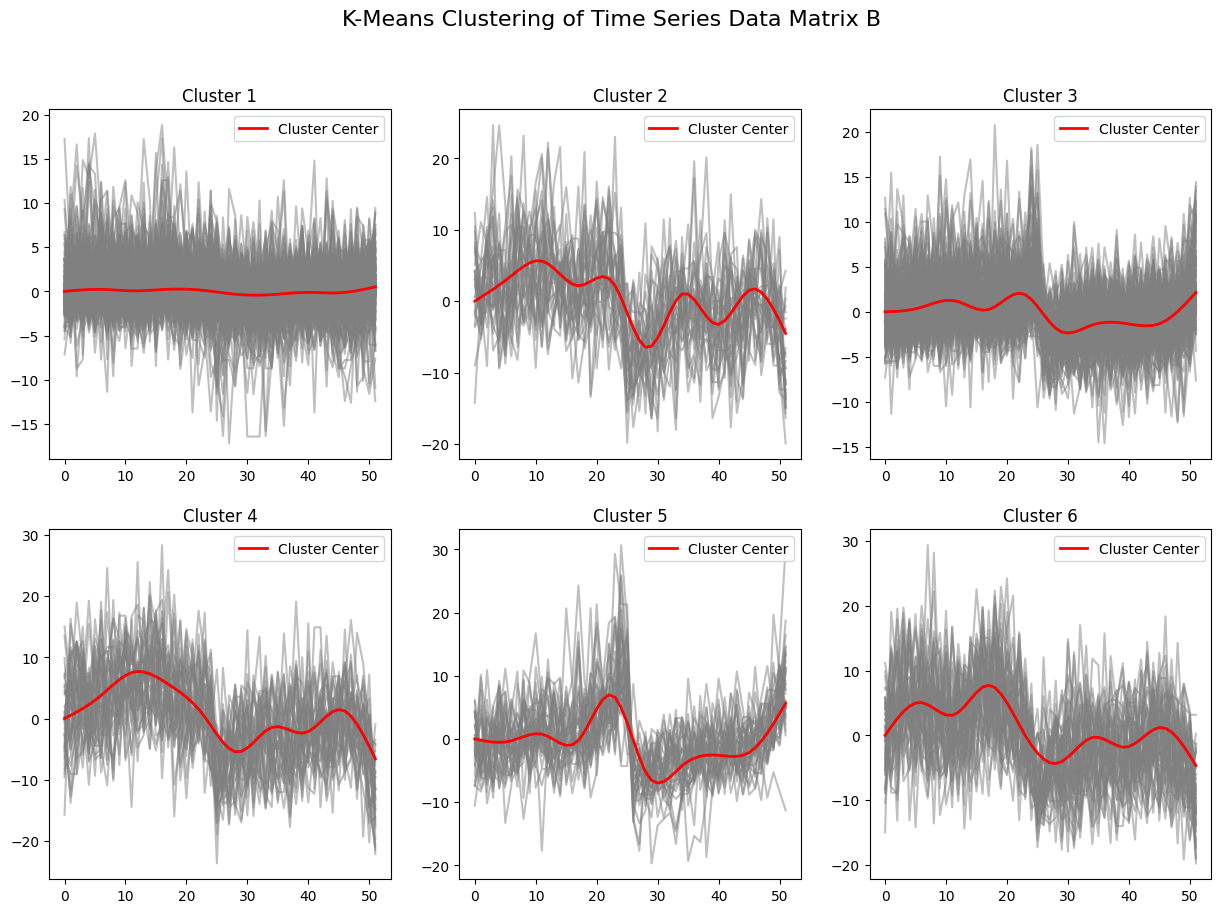

In [ ]:
# Visualize Centered Time Series with Cluster Matrix B
# Set up the plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

# Plot each cluster
for cluster_idx in range(num_clusters):
    # Get indices of products in the current cluster
    idx = np.where(labels == cluster_idx)[0]

    # Plot each time series in the cluster
    for i in idx:
        axs[cluster_idx].plot(X_centered[i], color='grey', alpha=0.5)  # Centered time series in grey

    # Calculate the corresponding time series from the cluster center b
    cluster_time_series = F_centered @ cluster_centers_b[cluster_idx] # Matrix product to get the corresponding time series

    # Plot the cluster center in red
    axs[cluster_idx].plot(cluster_time_series, color='red', linewidth=2, label='Cluster Center')

    # Add title and legend
    axs[cluster_idx].set_title(f'Cluster {cluster_idx + 1}')
    axs[cluster_idx].legend()


plt.suptitle('K-Means Clustering of Time Series Data Matrix B', fontsize=16)
plt.show()



In [ ]:
# Run K-Means clustering on X
kmeans.fit_predict(X_centered)
# Get the cluster labels and cluster centers in X space
labels = kmeans.labels_
centers = kmeans.cluster_centers_

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(num_clusters):
    # Get all products belonging to the current cluster
    cluster_indices = np.where(labels == i)[0]  # Indices of products in the i-th cluster

    # Plot all time series in grey for the i-th cluster
    for idx in cluster_indices:
        axes[i].plot(X_centered[idx,:], color='grey', alpha=0.5)

    # Overlay the cluster center in red
    axes[i].plot(centers[i], color='red', linewidth=2, label='Cluster Center')
    axes[i].set_title(f'Cluster {i + 1}')
    axes[i].legend()


plt.suptitle('K-Means Clustering of Time Series Data Matrix X', fontsize=16)

plt.show()




NameError: name 'plt' is not defined